# DSM 1128
## 主題: 【鐵達尼號的生存預測】<br>

關鍵字: #**探索性數據分析(Exploratory Data Analysis)** #**特徵工程(Feature Engineering)** #隨機森林(Random Forest)

Reference: https://colab.research.google.com/github/AI-FREE-Team/Data-Analytics-in-Practice-Titanic/blob/master/Data%20Analytics%20in%20Practice%20-%20Titanic%20Survival%20Prediction.ipynb?hl=zh-tw


鐵達尼號資料集（Titanic dataset）是 Kaggle 上非常知名且常用的入門資料集之一，適用於機器學習模型的分類問題。資料集的目的是預測鐵達尼號船難中哪些乘客能夠生還，哪些乘客不幸遇難。

### 資料集概覽
資料集包含了鐵達尼號上乘客的相關資料，這些資料包括他們的基本信息、船艙等級、票價、登船港口等。這些資訊將被用來預測每個乘客是否生還。

### 資料集欄位說明
1. **PassengerId**: 每個乘客的唯一標識符。
2. **Pclass**: 乘客的艙等（1、2、3），對應於頭等艙、二等艙和三等艙。
3. **Name**: 乘客的姓名。
4. **Sex**: 乘客的性別（male/female）。
5. **Age**: 乘客的年齡。缺失值需要處理。
6. **SibSp**: 乘客在船上的兄弟姐妹/配偶數量。
7. **Parch**: 乘客在船上的父母/子女數量。
8. **Ticket**: 乘客的票號。
9. **Fare**: 乘客支付的票價。
10. **Cabin**: 乘客的艙房號碼。這個欄位有很多缺失值。
11. **Embarked**: 乘客的登船港口，C = Cherbourg, Q = Queenstown, S = Southampton。
12. **Survived**: 目標變數，表示乘客是否生還，1 代表生還，0 代表遇難。

### 目標
利用訓練集中的乘客資料，建立一個分類模型來預測乘客是否會在鐵達尼號船難中生還。今天我們使用*隨機森林*來進行這個分類任務。

### 預處理步驟
1. **處理缺失值**: 如 Age 和 Cabin 等欄位可能會有缺失值，需要進行處理。Age 可以使用中位數填補，Cabin 可以標記為缺失或進行其他填補。
2. **編碼類別變數**: 如 Sex 和 Embarked 需要進行數字化編碼，通常使用 LabelEncoder 或 OneHotEncoding。
3. **特徵縮放**: 如 Fare 和 Age 可能需要進行縮放，以便適應模型的訓練。

### 模型訓練
使用像是 **隨機森林**（Random Forest）、**邏輯回歸**（Logistic Regression）等方法來預測乘客的生還情況。這些模型的性能通常會通過交叉驗證來評估。

### 評價指標
通常使用 **Accuracy**（準確率）來評估模型的預測效果，特別是當樣本不平衡時，也可能會使用 **F1-Score** 或 **AUC** 來衡量模型在預測生還和遇難的準確度。

In [1]:
#pip install sklearn
import pandas as pd
import numpy as np

# 繪圖相關套件
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use( 'ggplot' )

# 標籤編碼(Label)、獨熱編碼(OneHot)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# 決策樹(Decision Tree)
from sklearn.tree import DecisionTreeClassifier
# 隨機森林(Random Forest)
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display
import warnings
warnings.filterwarnings( 'ignore' )

In [ ]:
# from google.colab import files

# uploaded = files.upload()

## 1. 資料蒐集

### 1.1下載鐵達尼號資料集。
從kaggel下載鐵達尼號資料集，共有gender_submission.csv, test.csv, train.csv 三份檔案，並解壓縮後上傳至colabc或存放在本地端。
Link: https://www.kaggle.com/c/titanic/data



In [6]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
submit = pd.read_csv('gender_submission.csv')

print( f'train {df_train.shape}' )
display( df_train.head() )

print( f'\ntest {df_test.shape}' )
display( df_test.head() )

train (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



test (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 1.2 自定義function，查看資料型態
### function在做甚麼?
在程式設計中，**function**（函式）是一段可以重複使用的程式碼，它執行某個特定的任務或計算。你可以把它想像成一個「黑盒子」(我自己理解成一台機器)，你給它一些「輸入」，然後它會回傳一個「輸出」。就像是你給一個機器不同的麵粉，它會加工後產出不同種類的麵包。

簡單來說，函式可以做以下幾件事：

1. **執行特定任務**：例如，計算兩個數字的和，或是顯示一個訊息。
2. **接受輸入（參數）**：函式可以接收資料，這些資料就像是你給它的「工具」或「材料」。
3. **回傳結果**：函式運行完後，通常會有結果（像是計算的數字或處理過的資料），並回傳給你，讓你可以在程式其他地方使用。

### 比方說：
假設你有一個函式叫做 `addNumbers`，它會計算兩個數字的和：
```python
def addNumbers(a, b):
    return a + b
```
這個函式做的事就是把兩個數字 `a` 和 `b` 相加，然後回傳結果。當你執行這個函式時，你會給它兩個數字，像是 `addNumbers(3, 5)`，它會回傳 `8`。

總結來說，函式讓你能把常常使用的程式碼封裝起來，只要你需要它，就可以簡單地呼叫一次，而不必每次都重新寫一樣的程式碼！

In [7]:
# 定義判別欄位型態的函數
def Col_Types( Data ):
    Column_Types = Data.dtypes.to_frame().reset_index()   # 判別每個欄位的型態
    Column_Types.columns = ['ColumnName','Type']
    Column_Types.sort_values( by='Type', inplace=True )
    return Column_Types

In [8]:
display( Col_Types(df_train) )

,ColumnName,Type
0,PassengerId,int64
1,Survived,int64
2,Pclass,int64
6,SibSp,int64
7,Parch,int64
5,Age,float64
9,Fare,float64
3,Name,object
4,Sex,object
8,Ticket,object


## 2. 資料欲處理
### 2.1 遺失值(Missing Values)  
上一個專案我們有提到，在進行模型訓練跟資料分析之前，我先檢視資料是否存有遺失值(Missing Values)，如果欄位存有遺失值，之後在特徵工程(Feature Engineering)的過程中，我們可視欄位中遺失值的比例或對預測值的相關性，決定填補或排除此欄位的處理方法。

In [9]:
# 定義用來統計欄位缺漏值總數的函數
def Missing_Counts( Data ) :
    missing = Data.isnull().sum()  # 計算欄位中缺漏值的數量
    missing = missing[ missing>0 ]
    missing.sort_values( inplace=True )

    Missing_Count = pd.DataFrame( { 'ColumnName':missing.index, 'MissingCount':missing.values } )  # Convert Series to DataFrame
    Missing_Count[ 'Percentage(%)' ] = Missing_Count['MissingCount'].apply( lambda x:round(x/Data.shape[0]*100,2) )
    return  Missing_Count

In [10]:
print( 'train :' )
display( Missing_Counts(df_train) )

print( 'test :' )
display( Missing_Counts(df_test) )

train :


,ColumnName,MissingCount,Percentage(%)
0,Embarked,2,0.22
1,Age,177,19.87
2,Cabin,687,77.10


test :


,ColumnName,MissingCount,Percentage(%)
0,Fare,1,0.24
1,Age,86,20.57
2,Cabin,327,78.23


這邊可以觀察到Age, Cabin, Embarked, Fare欄位存有缺漏值，後續需要進行填補的處理方法。

### 2.2 基礎統計量(Statistic)

利用 describe( ) 函數，我們可得到每個數值型態欄位的統計量，其用意是為往後我們在觀察欄位是否存有離群值(Outlier)時，作為一個判斷的參考依據，另外，也可用來觀察每個欄位的尺度(scale)是否相似，在餵資料進入模型訓練之前，決定是否需進行資料的正規化(Normalization)或標準化(Standardization)。

In [11]:
print( 'train' )
display( df_train.describe() )

print( 'test' )
display( df_test.describe() )

train


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


test


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## 3. 資料分析(Data Analysis)

在大致瞭解資料的基本態樣後，我們便可開始對資料做一些關聯性分析。由於是對整體資料進行分析，因此我們先使用concat( )函數將train, test資料集合併，再進行分析。



In [ ]:
import seaborn as sns
import pandas as pd

# 合併 train 及 test 的資料
df_data = pd.concat([df_train, df_test], ignore_index=True)

# #合併train及test的資料
# df_data = df_train.append( df_test )
df_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### 3.1 生還者的比率(Survival Ratio)   

首先，我們分析生還者與罹難者的比例是否有明顯極大的落差，比如生還者的比例僅有 1%，若資料有極大的落差時，表示存在『數據不平衡』(Imbalanced Data)的問題，則後續需用特別的方法對資料進行抽樣。利用 value_counts( ) 函數，我們可以計算欄位中各相異類別的數量，船難中的生還者約佔全體乘客的 38.38%、罹難者約佔 61.62%。

In [14]:
Survived_Counts = df_data['Survived'].value_counts().reset_index()
Survived_Counts.columns = ['Survived','Counts']
Survived_Counts

,Survived,Counts
0,0.0,549
1,1.0,342


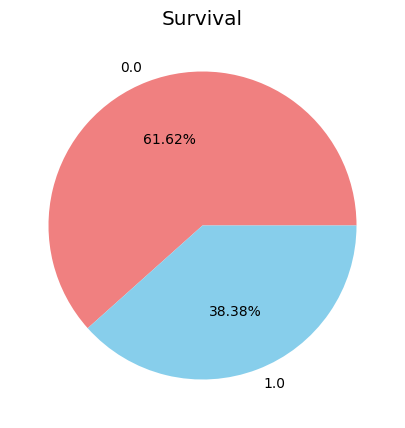

In [15]:
plt.figure( figsize=(10,5) )
df_data['Survived'].value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'Survival' )  # 圖標題
plt.ylabel( '' )
plt.show()

### 3.2 相關係數(Correlation)
利用 corr( ) 函數，計算特徵欄位彼此間的相關係數，可作為後續決定篩選哪些特徵欄位，來餵入模型進行訓練。觀察 Survived 欄位與其他特徵欄位的相關係數，發覺彼此間並無明顯的線性關係。

#### 如果在特徵之間存在線性相關性，這會對機器學習模型的表現和解釋性產生一些影響，具體表現在以下幾個方面：

1. 多重共線性問題（Multicollinearity）：

當兩個或多個特徵之間有高度的線性相關性時，會出現多重共線性問題。這會使得模型中的某些係數變得不穩定，且難以解釋。例如，在線性回歸中，若兩個特徵高度相關，模型可能無法準確區分它們的個別影響，導致回歸係數的估計不可靠。
多重共線性會增加估計標準誤差，使得回歸模型中的某些變數可能顯得不顯著，甚至可能對結果造成偏差。

2. 模型的過擬合風險：

如果模型同時利用了線性相關的多個特徵，可能會導致過擬合。過擬合是指模型過度擬合訓練數據，這樣它能在訓練數據上表現良好，但在測試數據或未知數據上表現較差。這是因為模型可能學到了不必要的噪音和冗餘資訊。

3. 維度冗餘：

如果特徵之間存在線性關聯，一些特徵的存在可能是多餘的。這會使得模型的解釋性變差，且可能增加計算成本。這時，進行特徵選擇或降維（如主成分分析PCA）可以幫助消除冗餘的特徵，從而簡化模型並提高性能。

In [ ]:
# Survied 與其他欄位間的相關係數
# 選擇數值型列
numeric_df_train = df_train.select_dtypes(include=['number'])

# 計算相關係數
Corr_Matrix = numeric_df_train.corr()

# 提取 'Survived' 與其他欄位的相關係數
Corr = Corr_Matrix.loc['Survived', :].sort_values()[:-1]
Corr = pd.DataFrame({'Survived': Corr})

Corr

,Survived
Pclass,-0.338481
Age,-0.077221
SibSp,-0.035322
PassengerId,-0.005007
Parch,0.081629
Fare,0.257307


### 3.3 生存率(Survival Rate)  

接下來，我們分別觀察性別(Sex)、票務艙(Pclass)、登船港口(Embarked)、兄弟姊妹配偶人數(SibSp)、父母子女人數(Parch)與生存率的關係。

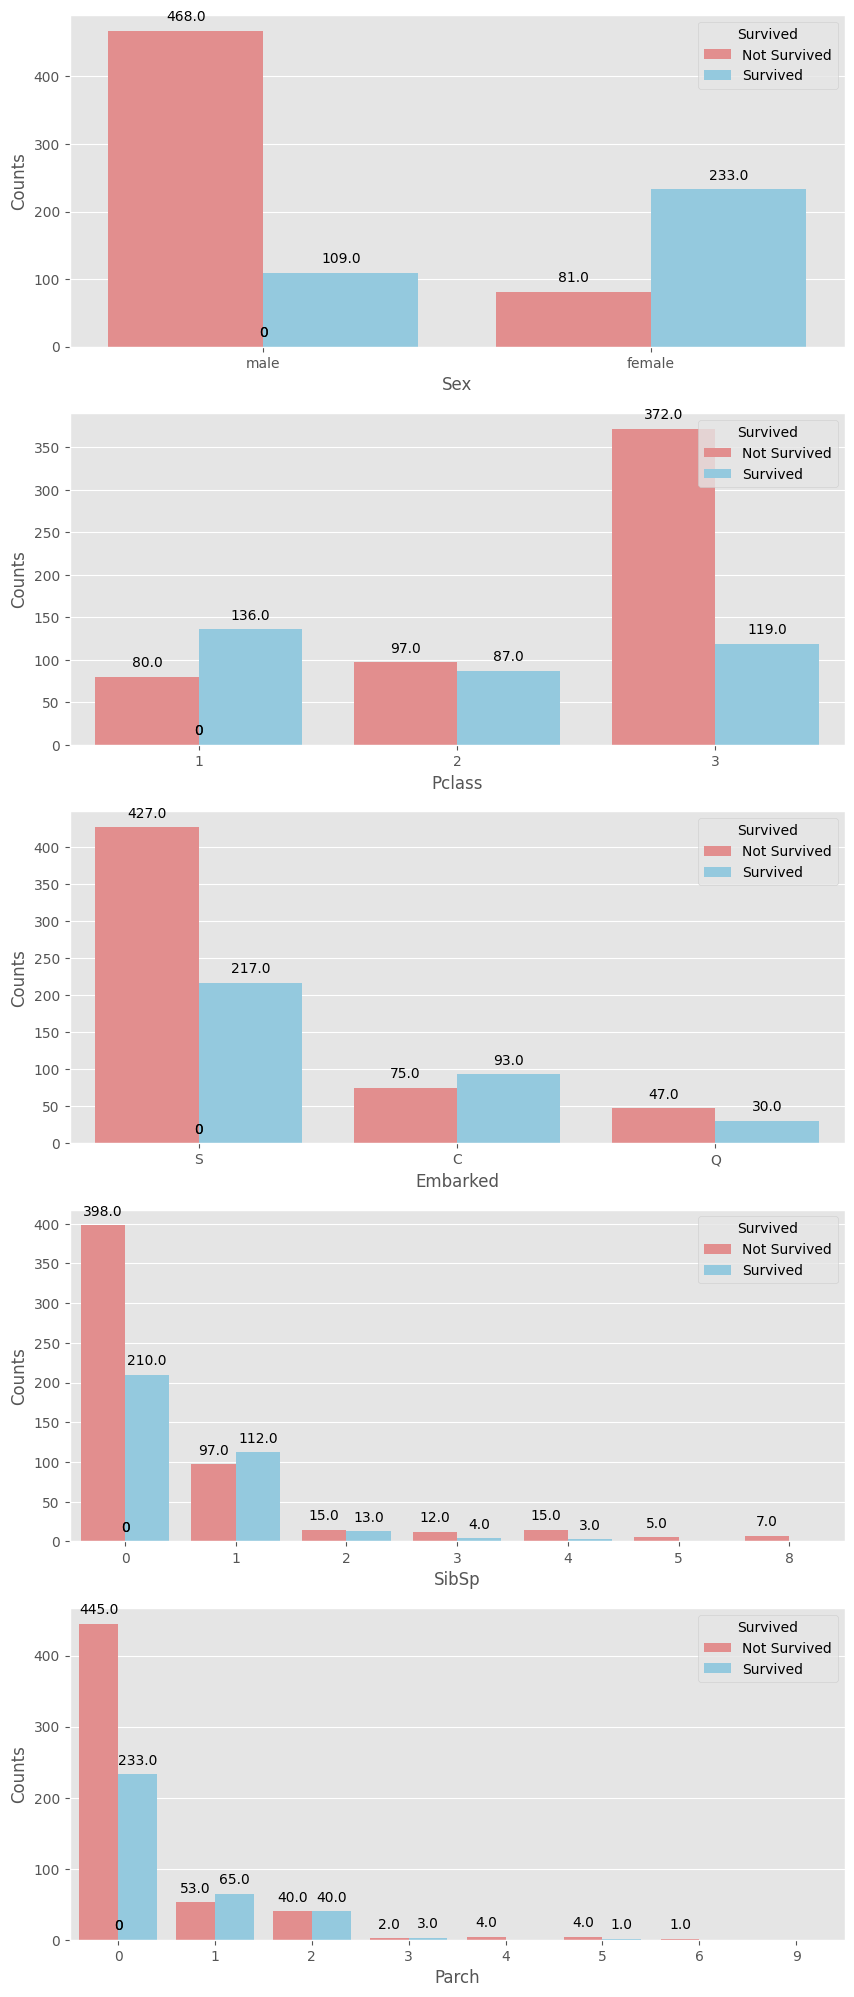

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# 將 0.0 替換為 'female'，1.0 替換為 'male'
df_data['Sex'] = df_data['Sex'].replace({0.0: 'female', 1.0: 'male'})

# Sex性別、Pclass票務艙、Embarked登船港口、SibSp兄弟姊妹配偶人數、Parch父母子女人數
selected_cols = ['Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']

plt.figure(figsize=(10, len(selected_cols) * 5))
gs = gridspec.GridSpec(len(selected_cols), 1)

for i, col in enumerate(selected_cols):
    ax = plt.subplot(gs[i])
    sns.countplot(x=col, hue='Survived', data=df_data, palette=['lightcoral', 'skyblue'], ax=ax)
    ax.set_ylabel('Counts')
    ax.legend(title='Survived', labels=['Not Survived', 'Survived'], loc=1)  # upper right:1 ; upper left:2
    for p in ax.patches:
        ax.annotate('{:,}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

In [22]:
for col in selected_cols:
    l = ['Survived']
    l.append(col)
    Survival_Rate = df_data[l].groupby(by=col).mean().round(4).reset_index()
    Survival_Rate.columns = [col,'Survival Rate(%)']
    Survival_Rate['Survival Rate(%)'] = Survival_Rate['Survival Rate(%)'].map( lambda x:x*100 )
    display( Survival_Rate )

,Sex,Survival Rate(%)
0,female,74.20
1,male,18.89


,Pclass,Survival Rate(%)
0,1,62.96
1,2,47.28
2,3,24.24


,Embarked,Survival Rate(%)
0,C,55.36
1,Q,38.96
2,S,33.70


,SibSp,Survival Rate(%)
0,0,34.54
1,1,53.59
2,2,46.43
3,3,25.00
4,4,16.67
5,5,0.00
6,8,0.00


,Parch,Survival Rate(%)
0,0,34.37
1,1,55.08
2,2,50.00
3,3,60.00
4,4,0.00
5,5,20.00
6,6,0.00
7,9,NaN


透過上列的長條圖(Bar Plot)與統計表，我們可得到下列的觀察：
* 女性的生存率明顯高於男性；  
* 票務艙($Pclass$)的生存率大小: Pclass 1 > Pclass 2 > Pclasss 3；
* 登船港口($Embarked$)的生存率以 C 最高；
* 當船上的兄弟姐妹配偶人數($SibSp$)有 1 人同行時，則生存率較高；
* 當船上的父母子女人數($Parch$)為 1~3 人時，有較高的生存率。